# Waveguides - Exc1

### Ronen shekel

### ID 309987493 

In [24]:
%matplotlib ipympl
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 15})

In [60]:
import simpleaudio as sa

def play_sound(sound):    
    CleanInput = sound.copy()
     # normalize to 16-bit range
    CleanInput *= 32767 / np.max(np.abs(CleanInput))
    
    # convert to 16-bit data
    CleanInput = CleanInput.astype(np.int16)
    # start playback
    play_obj = sa.play_buffer(CleanInput, 1, 2, fs)
    
    # wait for playback to finish before exiting
    play_obj.wait_done()

# Q1

## A - the signal

I plot the whole signal, and also a zoomed in version to the relevant parts to visualize the difference in frequencies.

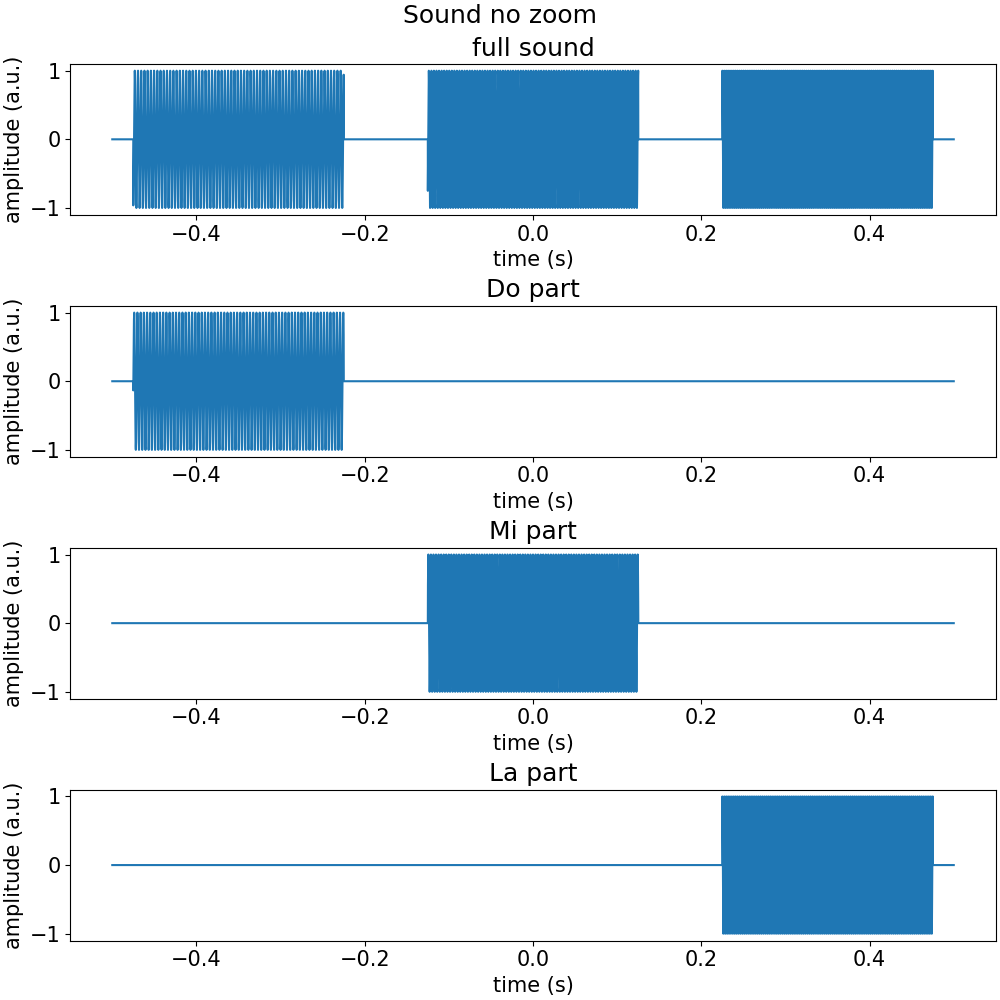

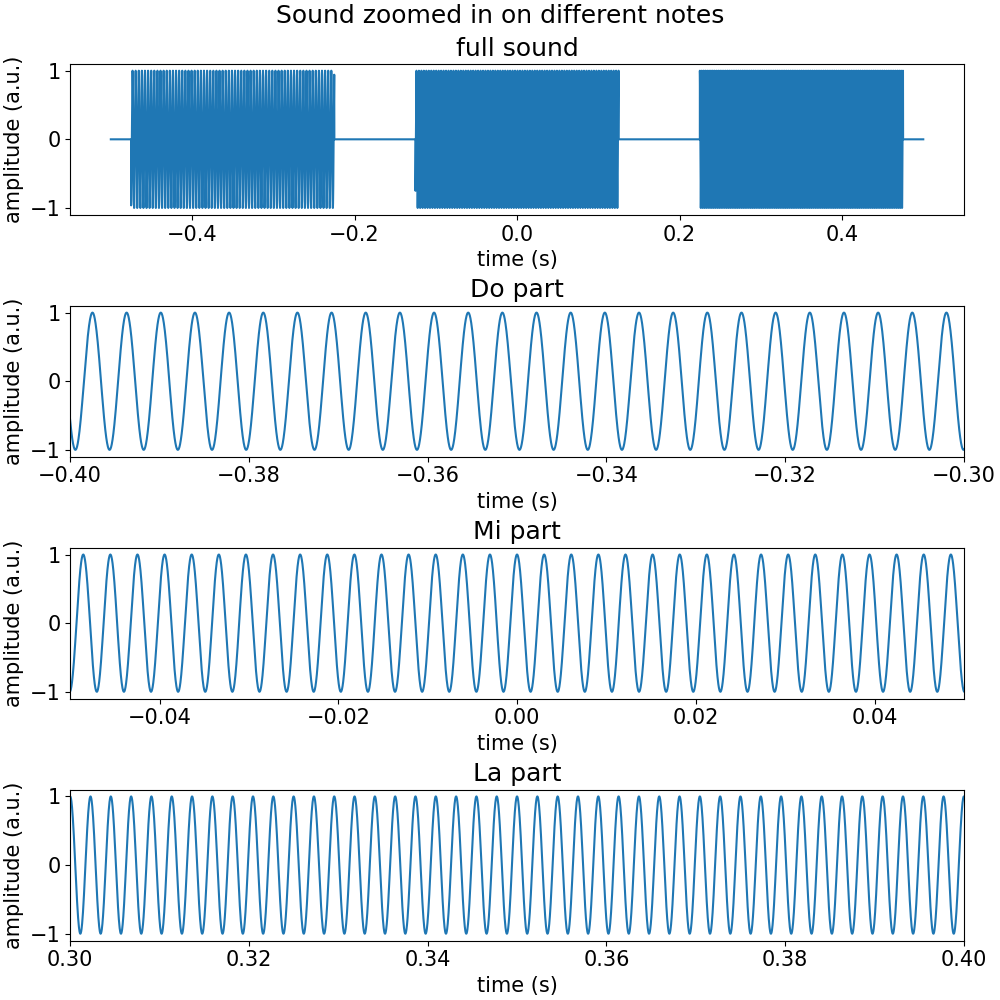

In [43]:
fs = 44100  # Sampling frequency                    
dt = 1/fs  # Sampling period       
L = 1      # Length of signal (in seconds)
L=L*fs
Do_freq = 261.63
Mi_freq = 329.63
La_freq = 440.0

def get_sound(with_noise=False):
    t = np.arange(0,L)*dt
    # Frequencies from here: https://mixbutton.com/mixing-articles/music-note-to-frequency-chart/
    Do = np.cos(2*np.pi*Do_freq*t) 
    Mi = np.cos(2*np.pi*Mi_freq*t)
    La = np.cos(2*np.pi*La_freq*t)
    
    # [0.025 silence; 0.25 Do; 0.1 silence; 0.25 Mi; 0.1 silence; 0.25 La; 0.025 silence; ] #
    sound = np.zeros_like(t)
    sound += ((0.025 < t) & (t < 0.275)) * Do 
    sound += ((0.375 < t) & (t < 0.625)) * Mi 
    sound += ((0.725 < t) & (t < 0.975)) * La 
    
    t -= 0.5 # centering around zero after placing the signals which is more intuitive beginning at zero
    
    if with_noise:
        pass
    
    return t, sound 

t, sound = get_sound()

def show_sound(t, sound, zoomed=False):
    fig, axes = plt.subplots(4, 1, constrained_layout=True)
    Do = np.cos(2*np.pi*261.63*t) 
    Mi = np.cos(2*np.pi*329.63*t)
    La = np.cos(2*np.pi*440.0*t)

    axes[0].plot(t, sound)
    axes[1].plot(t, ((0.025 < t + 0.5) & (t + 0.5 < 0.275)) * Do)
    axes[2].plot(t, ((0.375 < t + 0.5) & (t + 0.5 < 0.625)) * Mi)
    axes[3].plot(t, ((0.725 < t + 0.5) & (t + 0.5 < 0.975)) * La)
        
    if zoomed:
        fig.suptitle('Sound zoomed in on different notes')
        axes[1].set_xlim([-0.4, -0.3])
        axes[2].set_xlim([-0.05, 0.05])
        axes[3].set_xlim([0.3, 0.4])
    else:
        fig.suptitle('Sound no zoom')
    
    axes[0].set_title('full sound')
    axes[1].set_title('Do part')
    axes[2].set_title('Mi part')
    axes[3].set_title('La part')
    
    for ax in axes:
        ax.set_xlabel('time (s)')
        ax.set_ylabel('amplitude (a.u.)')
    
show_sound(t, sound, zoomed=False)
show_sound(t, sound, zoomed=True)

## B - the spectrum

I plot both the real+imag parts of the spectrum, and also the power spectrum which is more commonly used, and commonly defined as the square of the absolute power of the spectrum. I show only a zoomed in version on the relevant part, where there is another copy of this in the negative side, and the rest has zero amplitude. 

I show in DB only the power spectrum, since it makes sense only in this case, where it is defined positive. (the real+imag parts have negative values, where the log operation isn't defined.)

Text(0, 0.5, 'Amplitude [DB]')

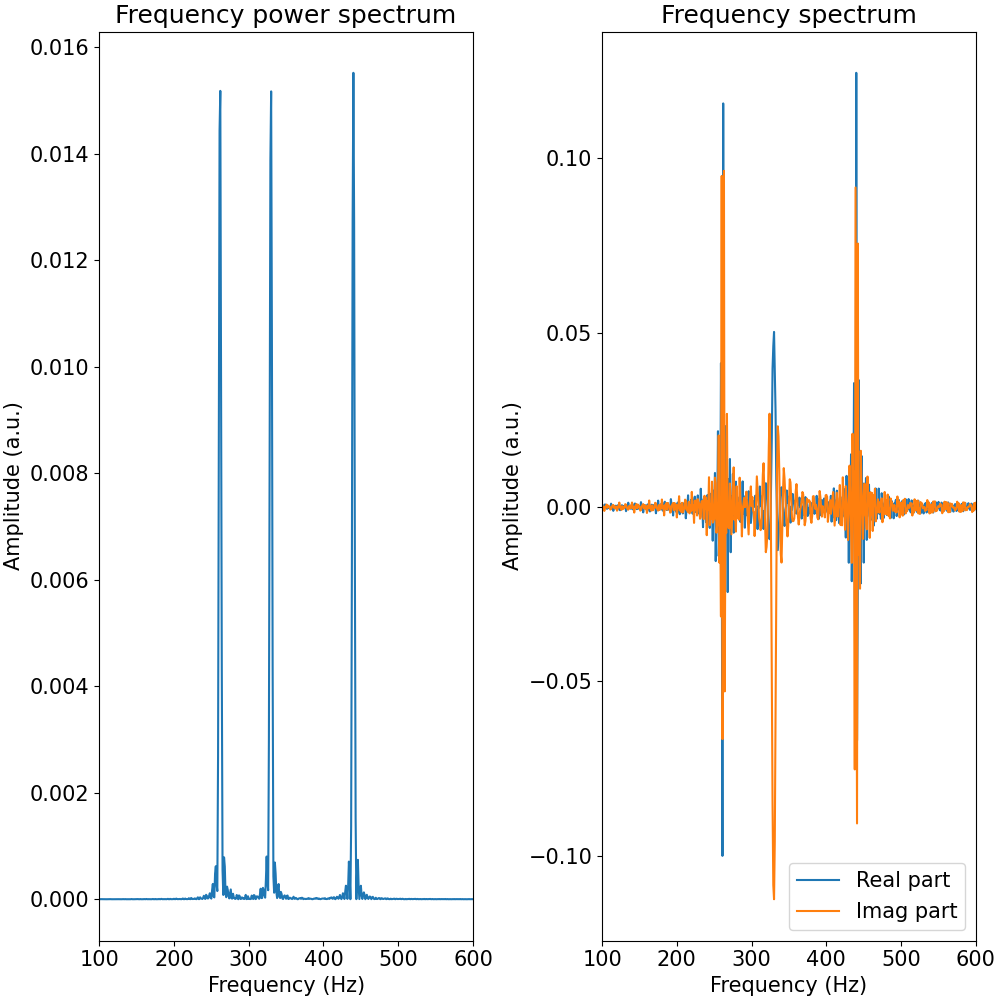

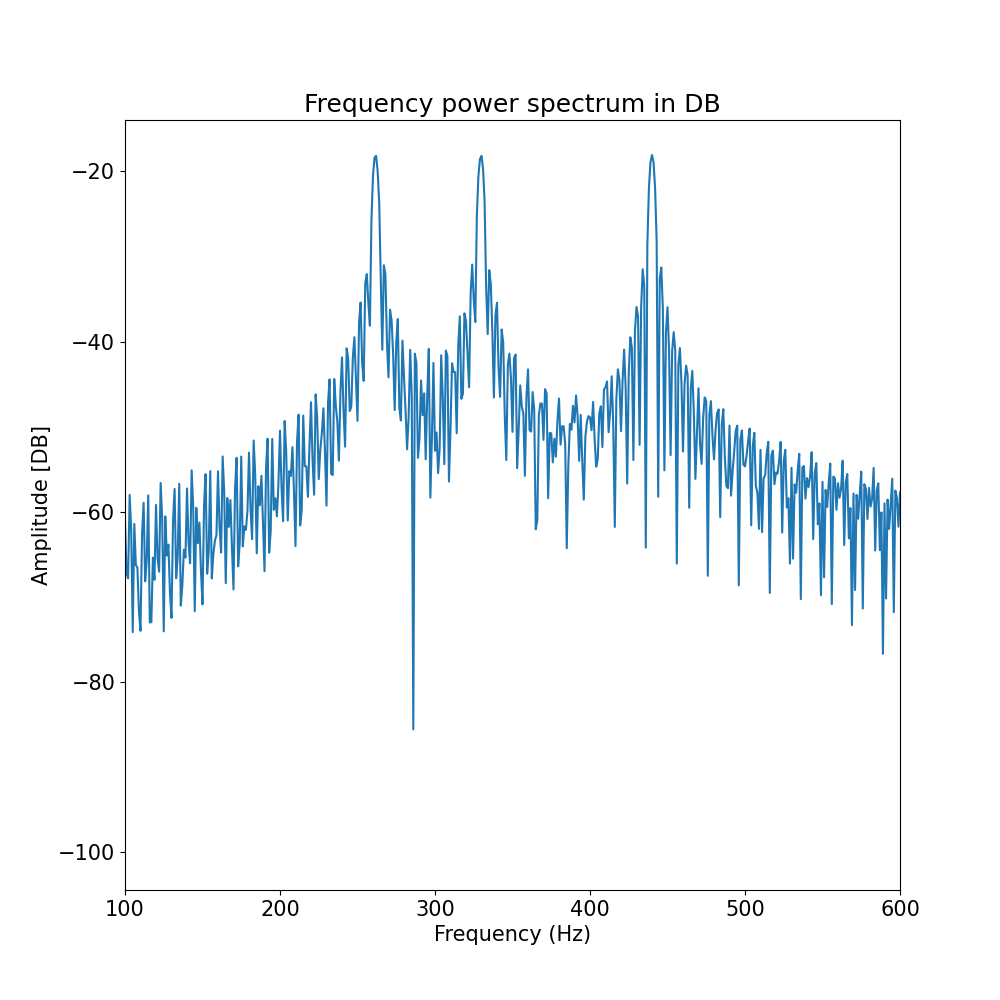

In [41]:
def show_spectrum(t, sound):
    freqs = np.fft.fftshift(np.fft.fftfreq(t.shape[-1], d=dt))  # Frequency vector, with zero properly placed at N/2+1 position.
    sound_F = np.fft.fftshift(np.fft.fft(np.fft.fftshift(sound))) / L  
    
    # Assume that by plotting the spectrum 
    fig, axes = plt.subplots(1, 2, constrained_layout=True)
    axes[0].plot(freqs, (np.abs(sound_F))**2)
    axes[0].set_xlim([100, 600])
    axes[0].set_title('Frequency power spectrum')
    axes[1].plot(freqs, np.real(sound_F), label='Real part')
    axes[1].plot(freqs, np.imag(sound_F), label='Imag part')
    axes[1].set_xlim([100, 600])
    axes[1].set_title('Frequency spectrum')
    axes[1].legend()
    for ax in axes:
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude (a.u.)')
    
    # And in DB
    fig, ax = plt.subplots()
    ax.plot(freqs, 10*np.log10((np.abs(sound_F))**2))
    ax.set_xlim([100, 600])
    ax.set_title('Frequency power spectrum in DB')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude [DB]')

show_spectrum(t, sound)

## C - filter 

I filter all frequencies with a RECT filter around Mi, remembering to also keep the negative frequencies around Mi. 

In the resulting filtered signal the main feature we see is what we wanted: we don't have the Do at the beginning or the La at the end, and we do have the Mi. However, we do see several artifacts: 
- bla 

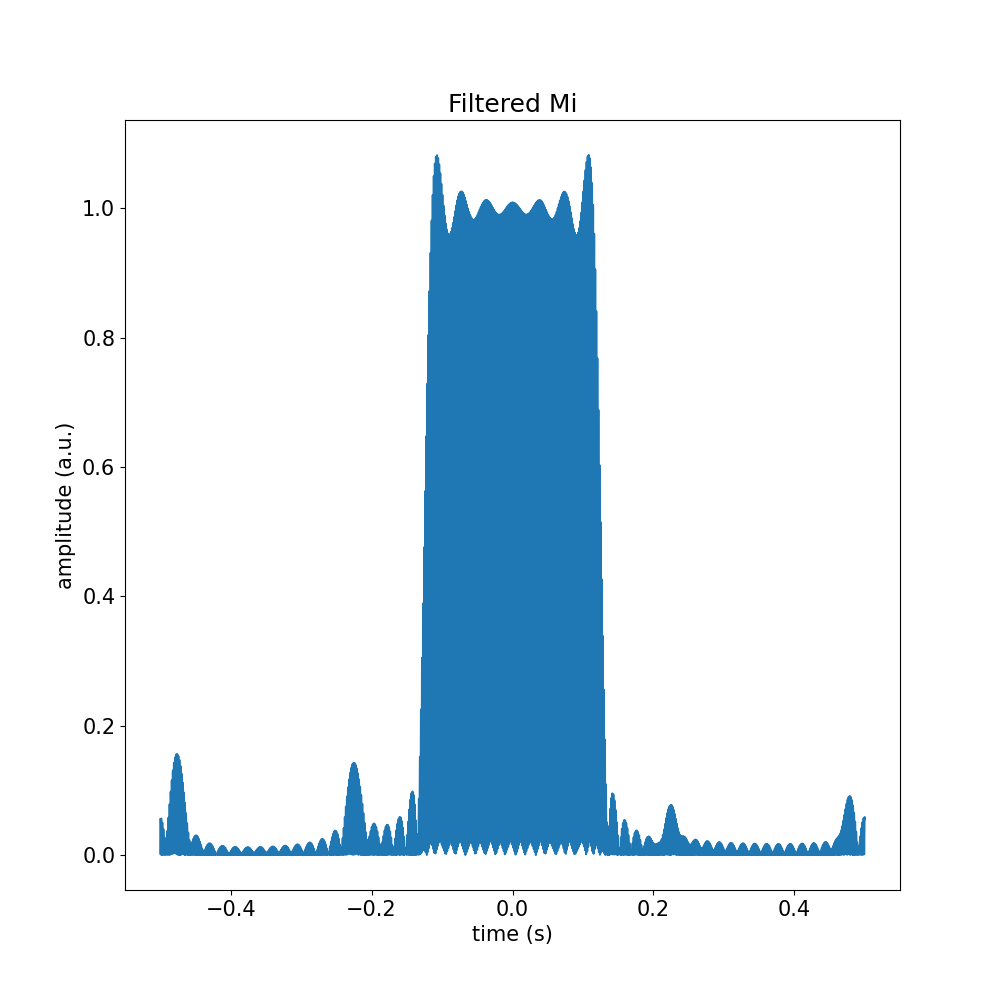

In [59]:
def show_filtered_Mi(t, sound, show_filtered_spectrum=False):
    freqs = np.fft.fftshift(np.fft.fftfreq(t.shape[-1], d=dt))  # Frequency vector, with zero properly placed at N/2+1 position.
    sound_F = np.fft.fftshift(np.fft.fft(np.fft.fftshift(sound))) / L
    
    Mi_filter = np.zeros_like(t)
    Mi_filter[np.abs((np.abs(freqs)-Mi_freq))<30] = 1 
    
    sound_F *= Mi_filter
    
    if show_filtered_spectrum:
        fig, ax = plt.subplots()
        ax.plot(freqs, (np.abs(sound_F))**2)
        ax.set_title('Filtered frequency power spectrum')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude [DB]')
    
    filtered_sound = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(sound_F)))*L
    
    fig, ax = plt.subplots()
    ax.plot(t, np.abs(filtered_sound))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_title('Filtered Mi')
    
show_filtered_Mi(t, sound, False)


# Signal with added noise

In [9]:
SNR=10 #in dB scale
Note_noise=(np.abs(t)<=(NoteDuration/2))*np.cos(2*np.pi*NoteFreq*t)+np.random.randn(Note.size)*np.sqrt(10**(-SNR/10)) #We made the signal real and even, which dictates that its frequency will be real. If it was odd, it would be imaginary.
max_Note  = np.max(Note_noise)

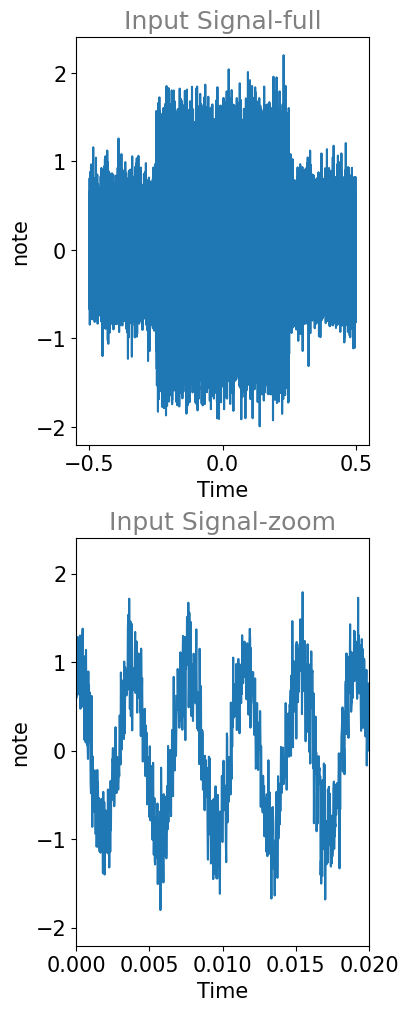

In [10]:

fig2, ax2 = plt.subplots(2,3, constrained_layout=True)

ax2[0, 0].plot(t,Note_noise)
# ax2[0,0].set_ylim((-1.1, 1.1))
ax2[0, 0].set_title('Input Signal-full', color = 'gray'), ax2[0, 0].set_xlabel('Time'), ax2[0, 0].set_ylabel('note')


ax2[1,0].plot(t,Note_noise)
# ax2[1,0].set_ylim((-1.1, 1.1))
ax2[1,0].set_xlim((0, 0.02))
ax2[1, 0].set_title('Input Signal-zoom', color = 'gray'), ax2[1, 0].set_xlabel('Time'), ax2[1, 0].set_ylabel('note')

for i in [1,2]:
    ax2[1, i].set_visible(False)
    ax2[0, i].set_visible(False)

# Play note

In [11]:
NoisyInput = Note_noise
 # normalize to 16-bit range
NoisyInput *= 32767 / np.max(np.abs(NoisyInput))

# convert to 16-bit data
NoisyInput = NoisyInput.astype(np.int16)

In [12]:
# start playback
play_obj = sa.play_buffer(NoisyInput, 1, 2, fs)

# wait for playback to finish before exiting
play_obj.wait_done()

In [13]:
Note_noise = max_Note*Note_noise/np.max(Note_noise)

# Signal at the Frequency-Domain

In [14]:
frequencies_noise = np.fft.fftshift(np.fft.fftfreq(t.shape[-1]))*fs  #Frequency vector, with zero properly placed at N/2+1 position.

NoteFourier_noise = np.fft.fftshift(np.fft.fft(np.fft.fftshift(Note_noise)))/L    

# Since the signal is neither even or odd, the spectrum is now complex. 
#  We use the power spectrum to visualize it

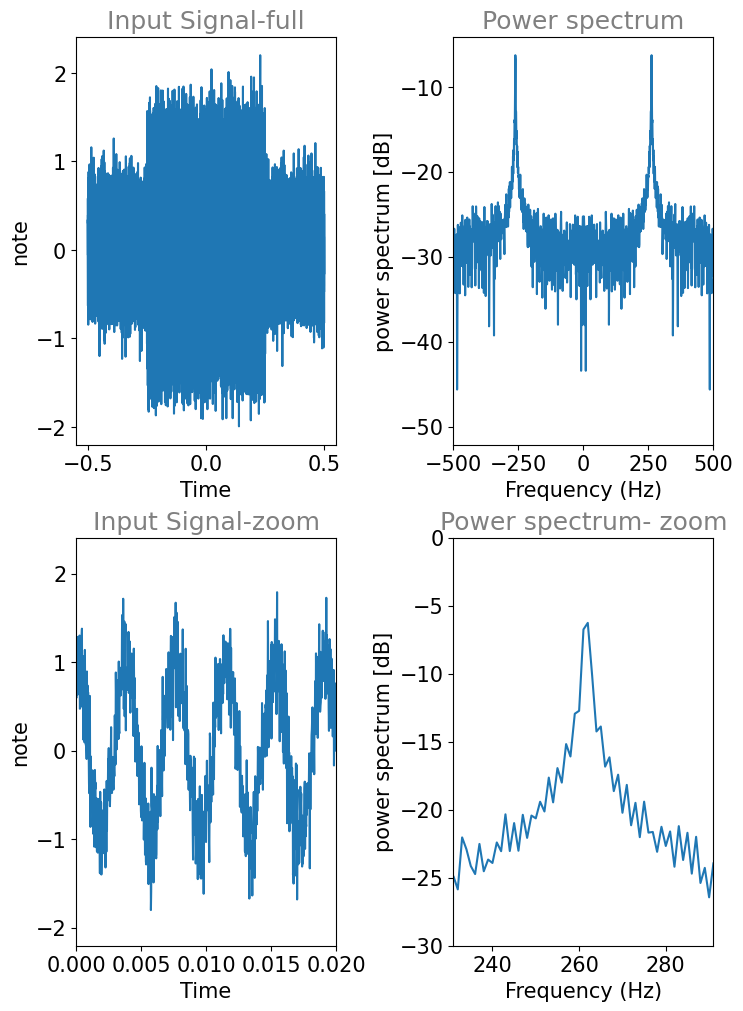

In [16]:
fig2, ax2 = plt.subplots(2,3, constrained_layout=True)

ax2[0, 0].plot(t,Note_noise)
# ax2[0,0].set_ylim((-1.1, 1.1))
ax2[0, 0].set_title('Input Signal-full', color = 'gray'), ax2[0, 0].set_xlabel('Time'), ax2[0, 0].set_ylabel('note')


ax2[1,0].plot(t,Note_noise)
# ax2[1,0].set_ylim((-1.1, 1.1))
ax2[1,0].set_xlim((0, 0.02))
ax2[1, 0].set_title('Input Signal-zoom', color = 'gray'), ax2[1, 0].set_xlabel('Time'), ax2[1, 0].set_ylabel('note')


ax2[0, 1].plot(frequencies_noise,10*np.log10(np.abs(NoteFourier_noise)))
ax2[0, 1].set_xlim((-500,500)), ax[0, 1].set_ylim((-60,0))
ax2[0, 1].set_title('Power spectrum', color='gray'), ax2[0, 1].set_xlabel('Frequency (Hz)'), ax2[0, 1].set_ylabel('power spectrum [dB]')

ax2[1, 1].plot(frequencies_noise,10*np.log10(np.abs(NoteFourier_noise)))
ax2[1, 1].set_xlim((231, 291)), ax2[1, 1].set_ylim((-30,0))
ax2[1, 1].set_title('Power spectrum- zoom', color='gray'), ax2[1, 1].set_xlabel('Frequency (Hz)'), ax2[1, 1].set_ylabel('power spectrum [dB]')


ax2[1, 2].set_visible(False)
ax2[0, 2].set_visible(False)

# bandpass filter

In [17]:
Power = np.min(np.log10(np.abs(NoteFourier_noise)))
Filter = (np.abs(np.abs(frequencies)-NoteFreq)<=10) + 10**Power

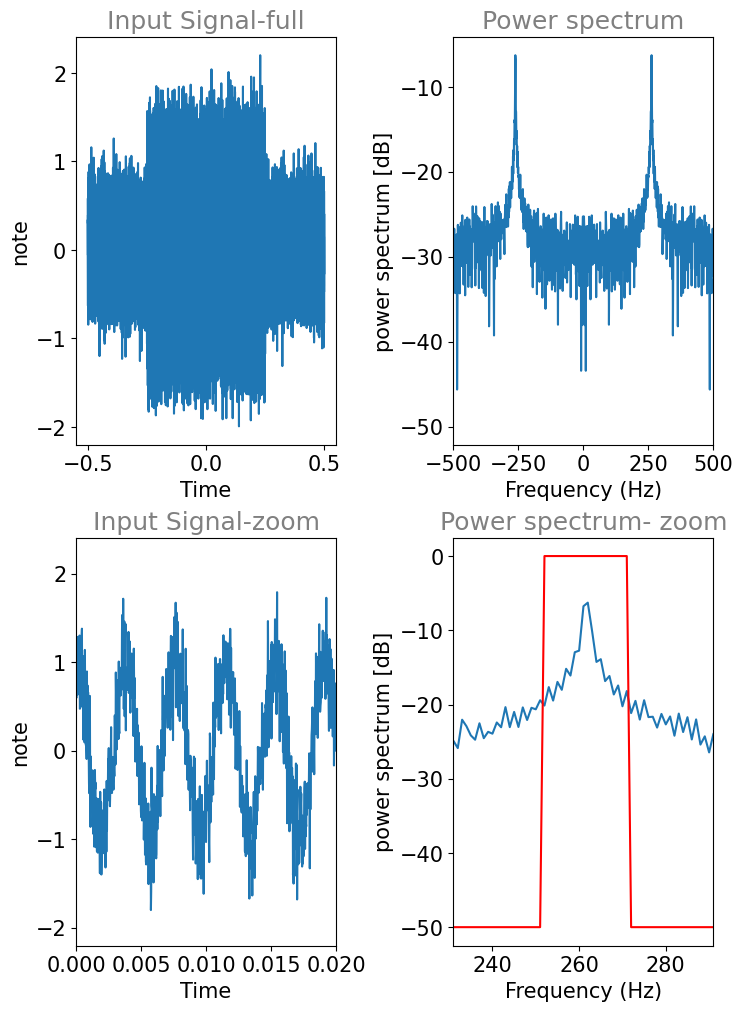

In [18]:
fig2, ax2 = plt.subplots(2,3, constrained_layout=True)

ax2[0, 0].plot(t,Note_noise)
# ax2[0,0].set_ylim((-1.1, 1.1))
ax2[0, 0].set_title('Input Signal-full', color = 'gray'), ax2[0, 0].set_xlabel('Time'), ax2[0, 0].set_ylabel('note')


ax2[1,0].plot(t,Note_noise)
# ax2[1,0].set_ylim((-1.1, 1.1))
ax2[1,0].set_xlim((0, 0.02))
ax2[1, 0].set_title('Input Signal-zoom', color = 'gray'), ax2[1, 0].set_xlabel('Time'), ax2[1, 0].set_ylabel('note')


ax2[0, 1].plot(frequencies_noise,10*np.log10(np.abs(NoteFourier_noise)))
ax2[0, 1].set_xlim((-500,500)), ax[0, 1].set_ylim((-60,0))
ax2[0, 1].set_title('Power spectrum', color='gray'), ax2[0, 1].set_xlabel('Frequency (Hz)'), ax2[0, 1].set_ylabel('power spectrum [dB]')

ax2[1, 1].plot(frequencies_noise,10*np.log10(np.abs(NoteFourier_noise)),frequencies_noise,10*np.log10(Filter),'r')
ax2[1, 1].set_xlim((231, 291)), #ax2[1, 1].set_ylim((-40,0.1))
ax2[1, 1].set_title('Power spectrum- zoom', color='gray'), ax2[1, 1].set_xlabel('Frequency (Hz)'), ax2[1, 1].set_ylabel('power spectrum [dB]')

ax2[1, 2].set_visible(False)
ax2[0, 2].set_visible(False)

# Filter signal in spectrum and return to time

In [19]:
FilteredFourier = NoteFourier_noise*Filter

FilteredNote = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(FilteredFourier)))*L

(Text(0.5, 1.0, 'Input Signal-full- zoom'),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'note'))

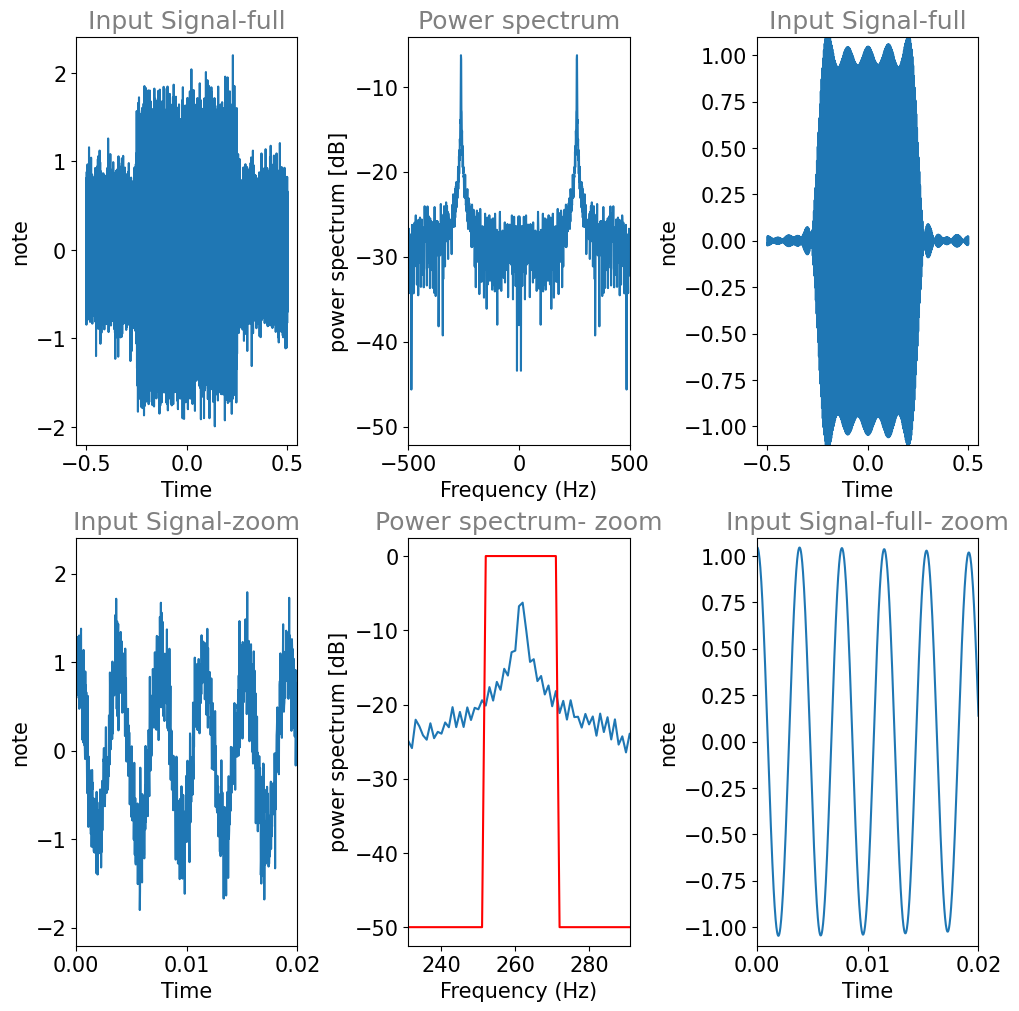

In [20]:
fig2, ax2 = plt.subplots(2,3, constrained_layout=True)

ax2[0, 0].plot(t,Note_noise)
# ax2[0,0].set_ylim((-1.1, 1.1))
ax2[0, 0].set_title('Input Signal-full', color = 'gray'), ax2[0, 0].set_xlabel('Time'), ax2[0, 0].set_ylabel('note')


ax2[1,0].plot(t,Note_noise)
# ax2[1,0].set_ylim((-1.1, 1.1))
ax2[1,0].set_xlim((0, 0.02))
ax2[1, 0].set_title('Input Signal-zoom', color = 'gray'), ax2[1, 0].set_xlabel('Time'), ax2[1, 0].set_ylabel('note')


ax2[0, 1].plot(frequencies_noise,10*np.log10(np.abs(NoteFourier_noise)))
ax2[0, 1].set_xlim((-500,500)), ax[0, 1].set_ylim((-60,0))
ax2[0, 1].set_title('Power spectrum', color='gray'), ax2[0, 1].set_xlabel('Frequency (Hz)'), ax2[0, 1].set_ylabel('power spectrum [dB]')

ax2[1, 1].plot(frequencies_noise,10*np.log10(np.abs(NoteFourier_noise)),frequencies_noise,10*np.log10(Filter),'r')
ax2[1, 1].set_xlim((231, 291)), #ax2[1, 1].set_ylim((-40,0.1))
ax2[1, 1].set_title('Power spectrum- zoom', color='gray'), ax2[1, 1].set_xlabel('Frequency (Hz)'), ax2[1, 1].set_ylabel('power spectrum [dB]')

ax2[0,2].plot(t, FilteredNote)
ax2[0,2].set_ylim(-1.1,1.1)
ax2[0,2].set_title('Input Signal-full',color='gray'), ax2[0,2].set_xlabel('Time'), ax2[0,2].set_ylabel('note')

ax2[1,2].plot(t, FilteredNote)
ax2[1,2].set_ylim(-1.1,1.1), ax2[1,2].set_xlim(0,0.02)
ax2[1,2].set_title('Input Signal-full- zoom',color='gray'), ax2[1,2].set_xlabel('Time'), ax2[1,2].set_ylabel('note')